# RDS Lab 8 and 9: DataSynthesizer

Today we will be talking about a privacy-preserving way to create synthetic data that (optionally) retains some useful characteristics of the original dataset. You can read about the DataSynthesizer in [Ping, Stoyanovich, and Howe (2017)](https://faculty.washington.edu/billhowe/publications/pdfs/ping17datasynthesizer.pdf). From the abstract:

> To facilitate collaboration over sensitive data, we present DataSynthesizer, a tool that takes a sensitive dataset as input and generates a structurally and statistically similar synthetic dataset with strong privacy guarantees. The data owners need not release their data, while potential collaborators can begin developing models and methods with some confidence that their results will work similarly on the real dataset.

We will cover three modes for generating synthetic data:
  1. random mode
  2. independent attribute mode
  3. correlated attribute mode

These modes are described in Ping, Stoyanovich, and Howe (2017, p.2):

> DataSynthesizer can operate in one of three modes: In correlated attribute mode, we learn a differentially private Bayesian network capturing the correlation structure between attributes, then draw samples from this model to construct the result dataset. In cases where the correlated attribute mode is too computationally expensive or when there is insufficient data to derive a reasonable model, one can use independent attribute mode. In this mode, a histogram is derived for each attribute, noise is added to the histogram to achieve differential privacy, and then samples are drawn for each attribute. Finally, for cases of extremely sensitive data, one can use random mode that simply generates type-consistent random values for each attribute.




In [1]:
# Install DataSynthesizer
!pip install DataSynthesizer

     |████████████████████████████████| 22.3MB 1.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
# Import packages
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

In [3]:
# Intialize a describer and a generator
describer = DataDescriber()
generator = DataGenerator()

## Preparation


In [4]:
# Packages for reading csv file into Colaboratory:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client. 
# Please follow the steps as instructed when you run the following commands. 

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
fileid_compas = '1TDNwGAEwzqODunv-MkQvKNU2b_JgjzB2'    
sensitive_data_file = 'adult_reduced.csv'

downloaded = drive.CreateFile({'id':fileid_compas}) 
downloaded.GetContentFile(sensitive_data_file)
# df_real = pd.read_csv(real_data_file)

In [6]:
# Set up some paths
description_files = {'random mode':                   'description(random).json', 
                     'independent attribute mode':    'description(independent).json', 
                     'correlated attribute mode':     'description(correlated).json'}
synthetic_data_files = {'random mode':                'synthetic data(random).csv', 
                        'independent attribute mode': 'synthetic data(independent).csv', 
                        'correlated attribute mode':  'synthetic data(correlated).csv'}

output_data_size = 1000

In [7]:
# Read in the data
real_data = pd.read_csv(sensitive_data_file)
real_data.head()

,age,education,sex,relationship,marital-status,income
0,39,Bachelors,Male,Not-in-family,Never-married,<=50K
1,50,Bachelors,Male,Husband,Married-civ-spouse,<=50K
2,38,HS-grad,Male,Not-in-family,Divorced,<=50K
3,53,11th,Male,Husband,Married-civ-spouse,<=50K
4,28,Bachelors,Female,Wife,Married-civ-spouse,<=50K


Take a moment to familiarize yourself with the above data.

## Random mode

In random mode, we replace the feature(s) that we want to protect with random values drawn from a uniform distribution:

In [8]:
describer.describe_dataset_in_random_mode(sensitive_data_file)

In [9]:
describer.save_dataset_description_to_file(description_files['random mode'])

#### Important parameters in random mode

Let's generate synthetic data in random mode. Pay attention to these parameters:

- __seed__: initialize the random number generator for both `random` and `np.random`
- __mininum__, __maximum__: determines the min and max of the random distribution from which we will draw the new values

In [10]:
generator.generate_dataset_in_random_mode(n=output_data_size, 
                                          description_file=description_files['random mode'], 
                                          seed=0, 
                                          minimum=0, 
                                          maximum=100)

Now let's save the synthetic data, read it as a pandas dataframe, and look at the data:

In [11]:
generator.save_synthetic_data(synthetic_data_files['random mode'])

In [12]:
synthetic_random = pd.read_csv(synthetic_data_files['random mode'])

In [13]:
real_data.head()

,age,education,sex,relationship,marital-status,income
0,39,Bachelors,Male,Not-in-family,Never-married,<=50K
1,50,Bachelors,Male,Husband,Married-civ-spouse,<=50K
2,38,HS-grad,Male,Not-in-family,Divorced,<=50K
3,53,11th,Male,Husband,Married-civ-spouse,<=50K
4,28,Bachelors,Female,Wife,Married-civ-spouse,<=50K


In [14]:
synthetic_random.head()

,age,education,sex,relationship,marital-status,income
0,44,Preschool,Male,Husband,Married-civ-spouse,<=50K
1,47,Some-college,Female,Husband,Separated,>50K
2,64,Assoc-acdm,Female,Not-in-family,Separated,<=50K
3,67,Masters,Male,Other-relative,Married-civ-spouse,<=50K
4,67,12th,Male,Own-child,Never-married,>50K


__Compare the two dataframes above (the real data and synthetic data we just generated):__
1. Look at the rows; how do the values of the real data and synthetic data compare? 
2. Do we need to consider something else apart from whether a particular value differs?

Text(0.5, 1.0, 'Random Mode')

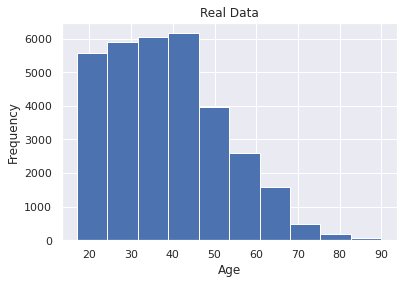

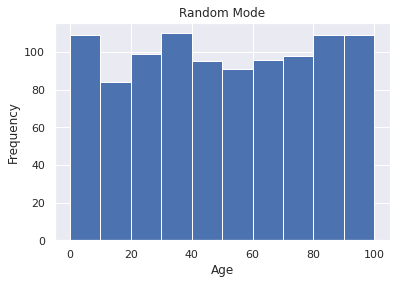

In [15]:
# plot the distribution of age in real_data and in synthetic_random
# write your code here
plt.figure(1)
real = plt.hist(real_data['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Real Data')

plt.figure(2)
random = plt.hist(synthetic_random['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Random Mode')

In [16]:
# compare the frequency of the different values of relationship status in real_data and synthetic_random (you can use a table and/or plots)
# write your code here
relationship_real = real_data['relationship'].value_counts()
relationship_random = synthetic_random['relationship'].value_counts()

relationship_both = pd.merge(relationship_real.to_frame(),
                             relationship_random.to_frame(),
                             left_index = True,
                             right_index = True,
                             suffixes = ('_real', '_random_mode'))

relationship_both

,relationship_real,relationship_random_mode
Husband,13193,156
Not-in-family,8305,159
Own-child,5068,189
Unmarried,3446,165
Wife,1568,166
Other-relative,981,165


We can pull more information on how the relationship feature is generated in random mode using the describer functions:

In [17]:
with open(description_files['random mode']) as f:
    description_json = json.load(f)

In [18]:
description_json.keys()

dict_keys(['meta', 'attribute_description'])

In [19]:
print(json.dumps(description_json['attribute_description']['relationship'], indent=4))

{
    "name": "relationship",
    "data_type": "String",
    "is_categorical": true,
    "is_candidate_key": false,
    "min": 4,
    "max": 14,
    "missing_rate": 0.0,
    "distribution_bins": [
        "Not-in-family",
        "Husband",
        "Wife",
        "Own-child",
        "Unmarried",
        "Other-relative"
    ],
    "distribution_probabilities": [
        0.16666666666666666,
        0.16666666666666666,
        0.16666666666666666,
        0.16666666666666666,
        0.16666666666666666,
        0.16666666666666666
    ]
}


## Independent attribute mode

In independent attribute mode, we replace the feature we want to protect with values that follow the same distribution as the original data. However, we do not consider any other features when determining the new value for the sensitive feature. 

In [20]:
describer.describe_dataset_in_independent_attribute_mode(sensitive_data_file, epsilon=0.1)

In [21]:
describer.save_dataset_description_to_file(description_files['independent attribute mode'])

Use ``generator.generate_dataset_in_independent_mode`` to generate synthetic data using the independent attribute mode. Hint: Look at the ``generate_dataset_in_random_mode`` code above if you are unsure how to proceed. You should set a seed, but you do not need to set a minimum or maximum:

In [22]:
# generate synthetic data in independent attribute mode
# write your code here using: generator.generate_dataset_in_independent_mode
generator.generate_dataset_in_independent_mode(n=output_data_size, 
                                          description_file=description_files['independent attribute mode'], 
                                          seed=0)


Now let's save the synthetic data we just generated in independent attribute mode, read it as a pandas dataframe, and view it:

In [23]:
generator.save_synthetic_data(synthetic_data_files['independent attribute mode'])

In [24]:
synthetic_independent = pd.read_csv(synthetic_data_files['independent attribute mode'])

In [25]:
synthetic_independent.head()

,age,education,sex,relationship,marital-status,income
0,42.0,HS-grad,Male,Not-in-family,Married-civ-spouse,<=50K
1,45.0,10th,Male,Not-in-family,Married-civ-spouse,<=50K
2,40.0,HS-grad,Male,Own-child,Divorced,<=50K
3,36.0,HS-grad,Female,Unmarried,Married-civ-spouse,<=50K
4,33.0,11th,Male,Own-child,Divorced,<=50K


Text(0.5, 1.0, 'After independent attribute mode')

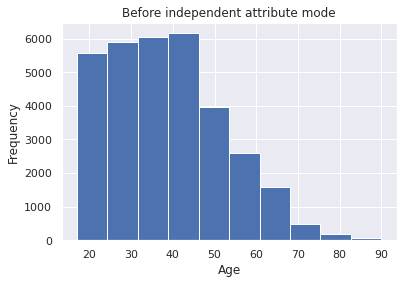

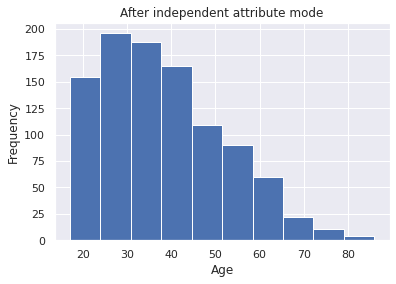

In [26]:
# Plot the distribution of age before and after being protected using independent attribute mode (i.e. in real_data and in synthetic_independent)
plt.figure(1)
plt.hist(real_data['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Before independent attribute mode')


plt.figure(2)
plt.hist(synthetic_independent['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('After independent attribute mode')

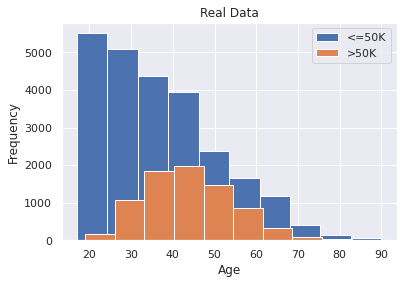

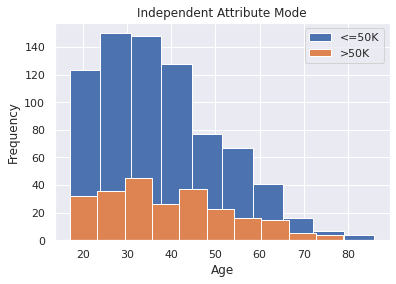

In [27]:
# Now plot the distribution of age by income group in the real data and in the synthetic data.
# Each plot should contain a histogram of age for all rows where income >50K and a histogram for age where income <=50k.

real_under_50 = real_data.loc[real_data.income == "<=50K"]
real_over_50 = real_data.loc[real_data.income == ">50K"]
plt.figure(1)
plt.hist(real_under_50['age'])
plt.hist(real_over_50['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Real Data')
plt.legend(labels = ['<=50K', '>50K'])

syn_under_50 = synthetic_independent.loc[synthetic_independent.income == "<=50K"]
syn_over_50 = synthetic_independent.loc[synthetic_independent.income == ">50K"]
plt.figure(2)
plt.hist(syn_under_50['age'])
plt.hist(syn_over_50['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Independent Attribute Mode')
plt.legend(labels = ['<=50K', '>50K'])


How do these distributions compare?

**Write your answer in this text cell:**

The synthetic data after protecting the real data with the independent attribute mode is slightly less skewed as a whole. The peak of the distribution appears to be more closer to the center of age values, which means the average and median of the protected attribute data is probably older than that before being protected by the independent attribute mode. 

Let's look at the distribution of relationship values in the real data and in the synthetic data generated using the independent attribute mode:

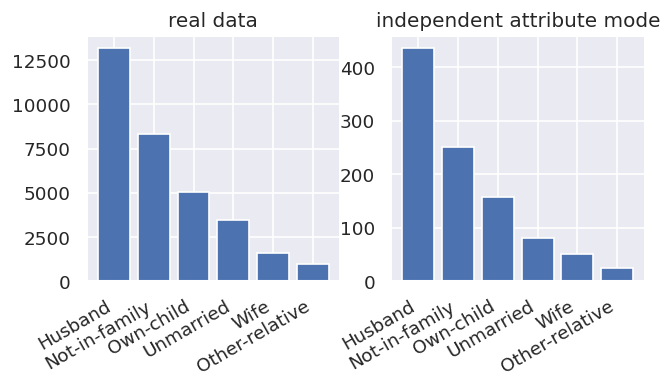

In [28]:
relationship_real = real_data['relationship'].value_counts()
relationship_independent = synthetic_independent['relationship'].value_counts()
relationship_both = pd.merge(relationship_real.to_frame(), 
                             relationship_independent.to_frame(), 
                             left_index=True, 
                             right_index=True, 
                             suffixes=('_real', '_independent_attribute_mode'))

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=120)
axes[0].bar(relationship_both.index, relationship_both['relationship_real'])
axes[1].bar(relationship_both.index, relationship_both['relationship_independent_attribute_mode'])
axes[0].set_title('real data')
axes[1].set_title('independent attribute mode')
fig.autofmt_xdate()

## Correlated attribute mode

The correlated attribute mode replaces the feature we want to protect with values based on the *conditional* distribution of all the features in the database. This is calculated using a Bayesian network.

In [29]:
describer.describe_dataset_in_correlated_attribute_mode(sensitive_data_file, 
                                                        epsilon=0.1, 
                                                        k=2)

================ Constructing Bayesian Network (BN) ================
Adding ROOT relationship
Adding attribute sex
Adding attribute marital-status
Adding attribute education
Adding attribute income
Adding attribute age
========================== BN constructed ==========================


In [30]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    sex            has parents ['relationship'].
    marital-status has parents ['sex', 'relationship'].
    education      has parents ['marital-status', 'relationship'].
    income         has parents ['marital-status', 'relationship'].
    age            has parents ['education', 'sex'].


In [31]:
describer.save_dataset_description_to_file(description_files['correlated attribute mode'])

Use generator.generate_dataset_in_correlated_attribute_mode to generate synthetic data using the correlated attribute mode:

In [32]:
# generate synthetic data in correlated attribute mode
# write your code here using: generator.generate_dataset_in_correlated_mode
generator.generate_dataset_in_correlated_attribute_mode(n=output_data_size,
                                              description_file=description_files['correlated attribute mode'],
                                              seed=0)

Again, save the data and read it as a pandas dataframe:

In [33]:
generator.save_synthetic_data(synthetic_data_files['correlated attribute mode'])

In [34]:
synthetic_correlated = pd.read_csv(synthetic_data_files['correlated attribute mode'])

Plot the distribution of age in the real data and synthetic data that you generated using the correlated attribute mode:

Text(0.5, 1.0, 'After correlated attribute mode')

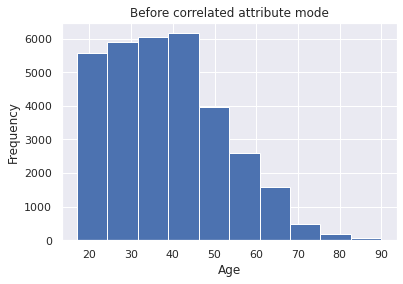

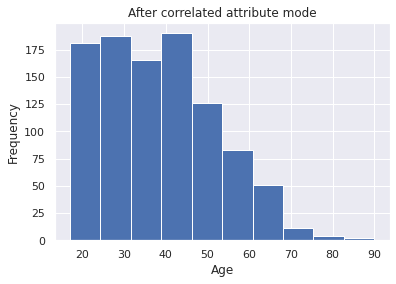

In [35]:
# plot the distribution of age in the real data and synthetic_correlated
plt.figure(1)
plt.hist(real_data['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Before correlated attribute mode')


plt.figure(2)
plt.hist(synthetic_correlated['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('After correlated attribute mode')

#### Plot the relationship between two variables to see if changes after protecting age





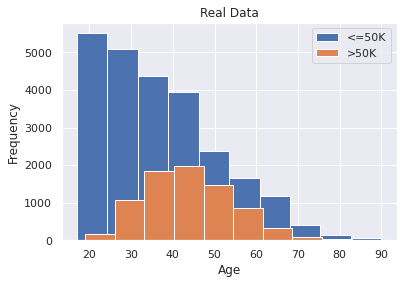

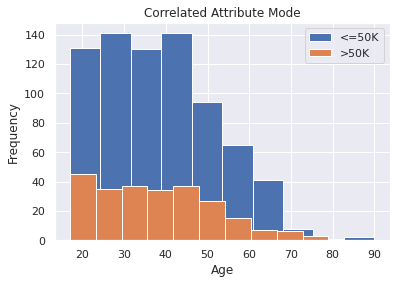

In [36]:
# write code here to plot the distribution of one variable by another variable
# in the real data and in synthetic_correlated
# e.g. plot age by education or age by income
real_under_50 = real_data.loc[real_data.income == "<=50K"]
real_over_50 = real_data.loc[real_data.income == ">50K"]
plt.figure(1)
plt.hist(real_under_50['age'])
plt.hist(real_over_50['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Real Data')
plt.legend(labels = ['<=50K', '>50K'])

corr_under_50 = synthetic_correlated.loc[synthetic_correlated.income == "<=50K"]
corr_over_50 = synthetic_correlated.loc[synthetic_correlated.income == ">50K"]
plt.figure(2)
plt.hist(corr_under_50['age'])
plt.hist(corr_over_50['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Correlated Attribute Mode')
plt.legend(labels = ['<=50K', '>50K'])

__Write down your observations here:__

Just as with the independent attribute mode, the correlated attribute mode is less skewed than the data that is not protected. The difference between the distributions of the two income groups also appears to be smaller for the correlated attribute mode. 

Are there differences in the distributions of the data generated by the correlated attribute mode and the independent attribute mode?

Text(0.5, 1.0, 'Independent Attribute Mode')

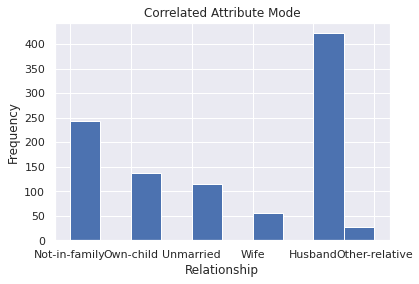

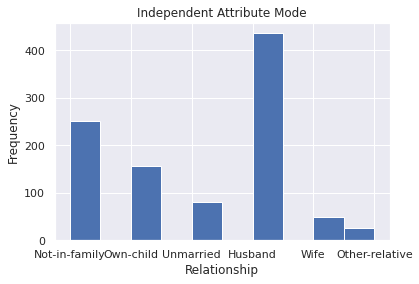

In [37]:
# plot the distribution of "relationship" in the synthetic data generated under the correlated attribute mode and the independent attribute mode here
plt.figure(1)
plt.hist(synthetic_correlated['relationship'])
plt.xlabel('Relationship')
plt.ylabel('Frequency')
plt.title('Correlated Attribute Mode')


plt.figure(2)
plt.hist(synthetic_independent['relationship'])
plt.xlabel('Relationship')
plt.ylabel('Frequency')
plt.title('Independent Attribute Mode')

## Statistical measures

### Mutual information

We can use mutual information to further understand how the relationships between features are similar/different in the real data and the synthetic data. Mutual information is defined as follows for two discrete variables X and Y:


$$I(X; Y) = \sum_{y \in Y} \sum_{x \in X} p(x,y) \log(\frac{p(x,y)}{p(x)p(y)})$$

Higher values indicate greater levels of mutual information. For two independent variables, the value will be zero (look at the logged term). This metric works for categorical variables *or* continuous variables. 

In [38]:
from sklearn.metrics import normalized_mutual_info_score

In [39]:
normalized_mutual_info_score(real_data['marital-status'], 
                             real_data['relationship'], 
                             average_method='arithmetic')

0.5249037668258572

In [40]:
normalized_mutual_info_score(real_data['marital-status'], 
                             real_data['education'], 
                             average_method='arithmetic')

0.014483450445067415

We can even plot the mutual information between all pairs of features in the dataset:

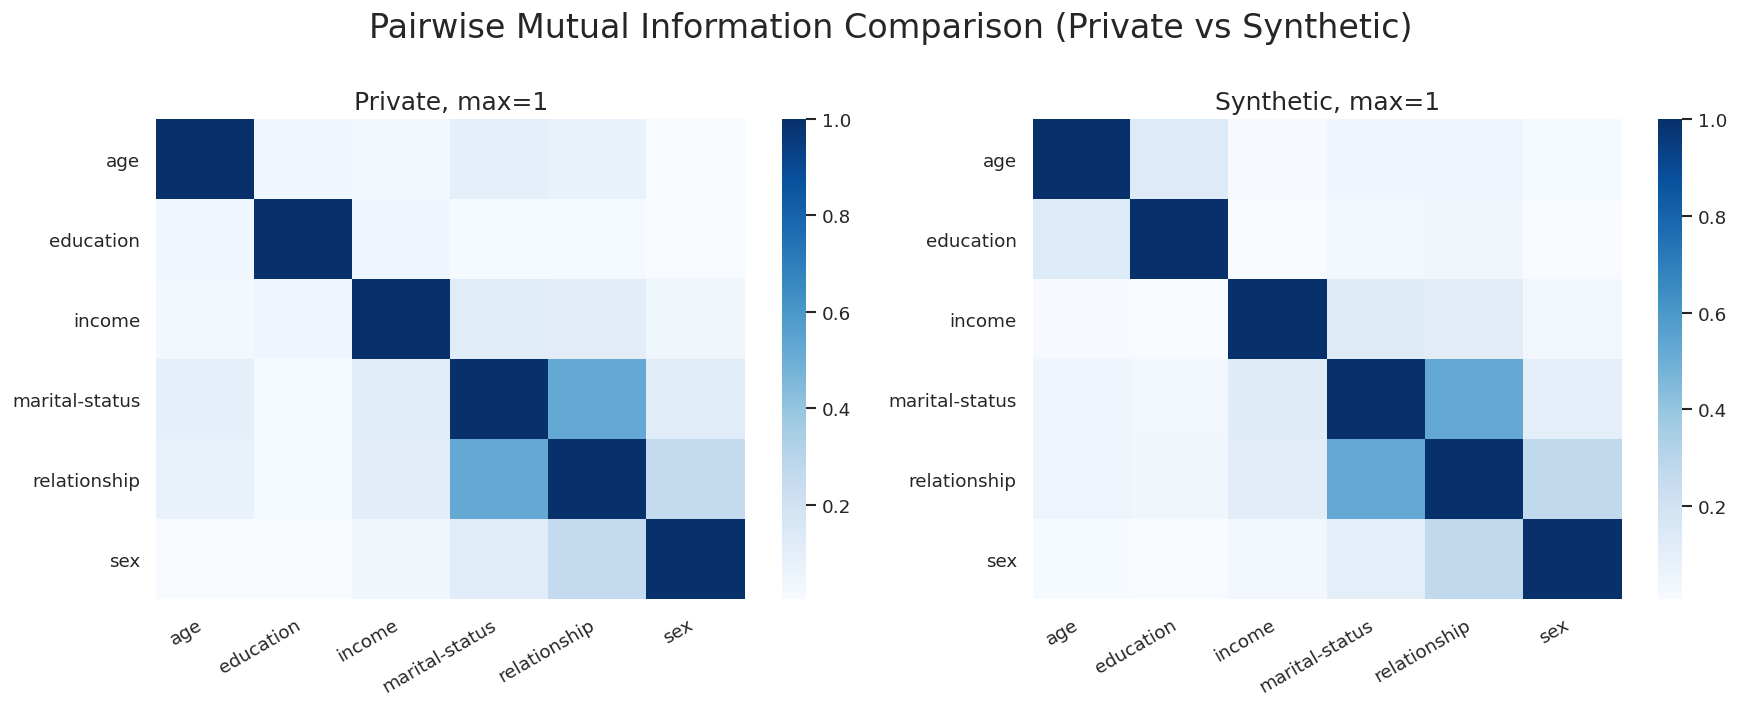

In [41]:
attribute_description = read_json_file(description_files['correlated attribute mode'])['attribute_description']
ModelInspector(real_data, 
               synthetic_correlated, 
               attribute_description).mutual_information_heatmap()

### Two-sample Kolmogorov–Smirnov test

The Kolmogorov-Smirnov test quantifies the similarity between the empirical distribution functions two sets of data. We can use it to measure how well the distribution of our synthetic data mimics the distribution of the original dataset. 

For two empirical distributions P and Q, the Kolmogorov–Smirnov test statistic is defined as:

$$D = \max_x |P(x) - Q(x)|$$

Intuitively, think of plotting the CDF of each dataset. The Kolmogorov–Smirnov test statistic is the maxium distance between the two CDFs. 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cf/KS_Example.png">

This metric only works for continuous variables. 

In [42]:
from scipy.stats import ks_2samp

In [43]:
def ks_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for Two-sample Kolmogorov–Smirnov test.
    """
    return ks_2samp(df_in[attr], df_out[attr])[0]

In [44]:
ks_test(real_data, synthetic_random, 'age')

0.33259405423666355

In [45]:
ks_test(real_data, synthetic_independent, 'age')

0.04653290746598687

In [46]:
ks_test(real_data, synthetic_correlated, 'age')

0.018629556831792626

What do you notice about the Kolmogorov–Smirnov test statistic in the synthetic_random versus the synthetic_independent and synthetic_correlated modes?

**Write your observations in this text cell:**
Synthetic independent is much smaller than synthetic random and synthetic correlated is even smaller than the other two.

### KL-divergence

The KL-divergence is an alternative way to measure the difference between two distributions. For two distributions P and Q, the KL-divergence is defined as 

$$D = \sum_x P(x) \log (\frac{P(x)}{Q(X)})$$

This metric works on discrete/categorical variables.


In [47]:
from scipy.stats import entropy

In [48]:
def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
    distribution.sort_index(inplace=True)
    return distribution/sum(distribution)

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)
    return entropy(distribution_out, distribution_in)

In [49]:
kl_test(real_data, synthetic_random, 'relationship')

0.37194502301936416

In [50]:
kl_test(real_data, synthetic_independent, 'relationship')

0.004852757128718812

In [51]:
kl_test(real_data, synthetic_correlated, 'relationship')

0.0027570713157389955

### Boxplot

It is often useful to the compare distributions of a continuous variable using a boxplot. For example, we plot the distribution of age by income status in the real data and in the synthetic_correlated data below:

In [52]:
import seaborn as sns

In [53]:
real_data.head()

,age,education,sex,relationship,marital-status,income
0,39,Bachelors,Male,Not-in-family,Never-married,<=50K
1,50,Bachelors,Male,Husband,Married-civ-spouse,<=50K
2,38,HS-grad,Male,Not-in-family,Divorced,<=50K
3,53,11th,Male,Husband,Married-civ-spouse,<=50K
4,28,Bachelors,Female,Wife,Married-civ-spouse,<=50K


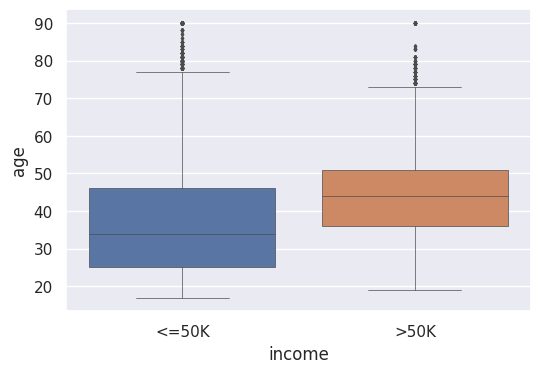

In [54]:
plt.figure(dpi=100)
sns.boxplot(x='income', y='age', data=real_data, linewidth=0.5, fliersize=2);

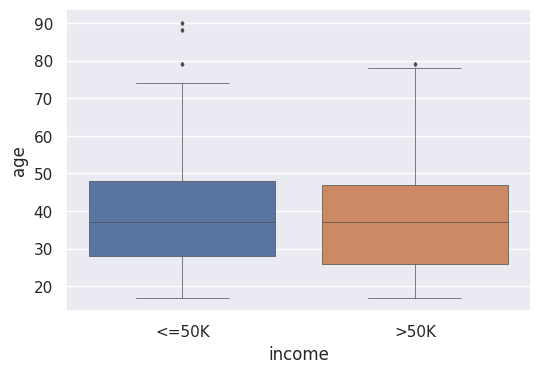

In [55]:
plt.figure(dpi=100)
sns.boxplot(x='income', y='age', data=synthetic_correlated, linewidth=0.5, fliersize=2);